Idea Training Process:
1. Load training set (labels with corresponding input TIFs)
2. Create cutouts of labeled training data
3. Train model on data
4. Evaluate model

Idea Prediction Process:
5. Create cutouts of unlabeled data
6. Predict cutouts

Function Overview
Training: load labels -> create_cutouts(label_file) -> fit(unlabeled_cutouts, labeled_cutouts) -> evaluate(?)
Prediction: load dats -> create_cutouts(label_file) -> predict(unlabeled_cutouts)

## 0. Imports

In [1]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds #Window
from rasterio.enums import Resampling
from sys import platform

In [2]:
# for coloured print statements
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

In [4]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)

### 0.1 Data Inspection

In [5]:
def inspect_tif_resolution(filepath):
    img = rasterio.open(filepath)
    xRes, yRes = img.res
    print("Resolution: {} x {}".format(xRes, yRes))   

In [6]:
def inspect_tif(dataset):
    # print("Metadata:", dataset.GetMetadata())
    # print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(int(min),int(max)))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[5])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    print("Size of one Pixel in cm = {}".format(tuple([100000*x for x in pixel_size])))
    print("Size Covered by Image / Image Size = ({}m, {}m)".format(round(1000*size_x, 2), abs(round(1000*size_y, 2))))

In [7]:
def isfile(filepath: str = None):
    # if filepath does not exists, an error is thrown
    if not os.path.isfile(filepath): raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath) #print("File does not exist.")

In [8]:
def preview_tif(tif_filepath: str = None):
    isfile(tif_filepath)
    img = rasterio.open(tif_filepath)
    if img: show(img)
    else: print("img unable to be loaded at this moment")

## 1. Development

### 1.1 Compare Satellite Image with Label

In [9]:
# TODO: use patchify to download patches in a certain size

In [76]:
def compare_satellite_label(satellite, label):
    # file =  rasterio.open(complete_filepath)
    filepath_satellite, filepath_label = path_satellite + satellite, path_labels + label
    # check if filepath exists
    if not os.path.isfile(filepath_satellite) or not os.path.isfile(filepath_label):
        print(f"{bcolors.FAIL}1 Failure: File(s) do(es) not exist: {complete_filepath}{bcolors.ENDC}") 
        return
    
    src_label = rasterio.open(filepath_label)
    src_satellite = rasterio.open(filepath_satellite)

    left, top = src_satellite.bounds[0], src_satellite.bounds[3]
    patch_size = 512
    overlap = 32 # similar to previous project: 0.12 * 256 = 30.72
    xRes, yRes = src_satellite.res # or: src.meta['transform'][0], -src.meta['transform'][4]    
    x_cutout_max, y_cutout_max = int(src_satellite.width / patch_size), int(src_satellite.height / patch_size)
    # print("max cutout:", x_cutout_max, y_cutout_max)

    # tmp testing
    x_cutout_max = 10
    y_cutout_max = 3
    # skip first row, because no data there
    # left, top, right, bottom = 29.748021463931796, -26.24839922837354, 29.74923634485858, -26.249614109300325
    # left, top = 29.761112169, -26.262076578039085
    
    for y_cutout in range(y_cutout_max):
        for x_cutout in range(x_cutout_max):

            right  = left + patch_size * xRes 
            bottom = top  - patch_size * yRes

            # print("({}, {}, {}, {})".format(left, top, right, bottom)) #Cutout Window: 
            print("Size of cutout window in px: {} x {}".format((right - left) / xRes, (top - bottom) / yRes))
            cutout_satellite = src_satellite.read(1, window = from_bounds(left, bottom, right, top, src_satellite.transform))
            cutout_label = src_label.read(1, window = from_bounds(left, bottom, right, top, src_label.transform))
            
            show(cutout_satellite)
            show(cutout_label)
            
            # adjust cutout window for next iteration (with 30 px overlap to cover trees on the edge)
            # adjust cutout window on the x-axis => move cutout window to the right - the overlap
            left = right - overlap * xRes # use right as a base and move left by the overlap  
            right  = left + patch_size * xRes # move patch_size to the right from left # += patch_size * xRes
        # reset the x-axis
        left = src_satellite.bounds[0]
        right  = left + patch_size * xRes
        # adjust cutout window on the y-axis => move cutout window to the bottom
        top = bottom - overlap * yRes
        bottom = top - patch_size * yRes # -= patch_size * yRes

    src_satellite.close()
    src_label.close()

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


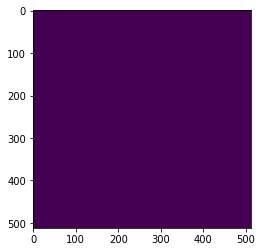

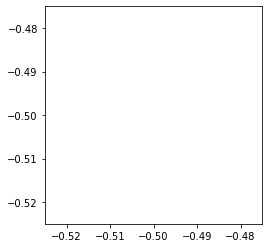

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


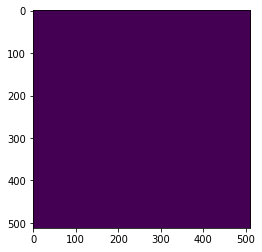

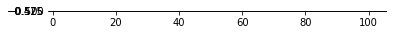

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


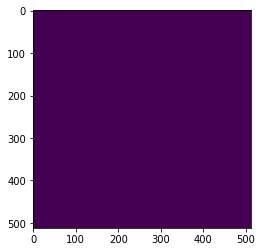

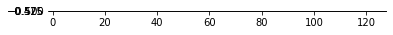

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


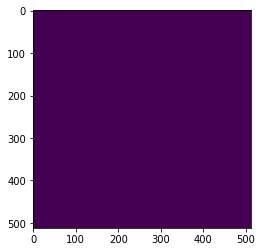

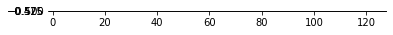

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


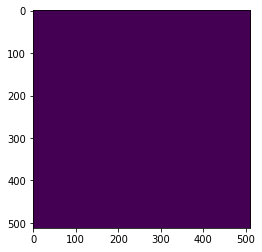

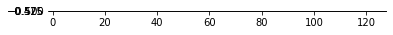

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


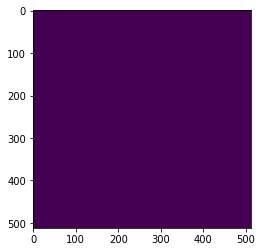

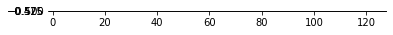

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


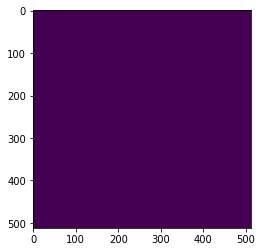

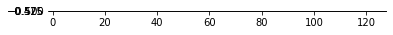

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


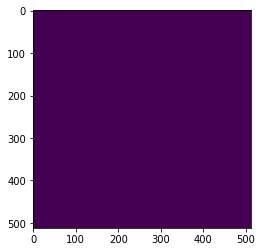

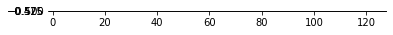

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


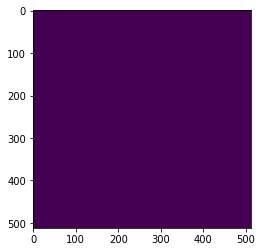

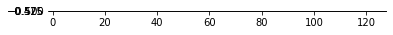

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


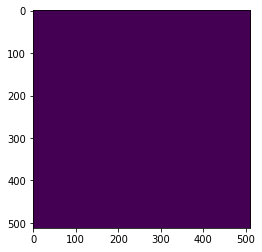

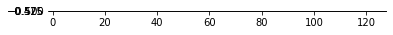

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


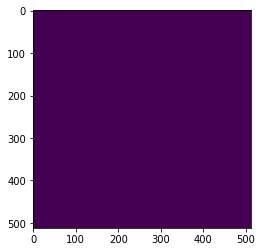

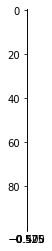

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


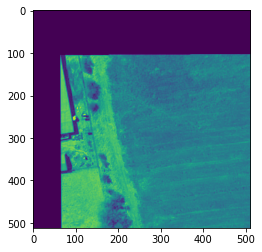

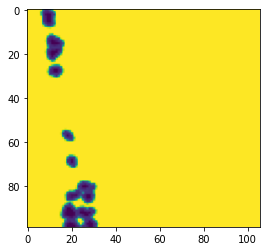

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


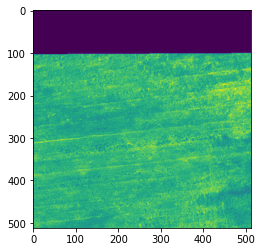

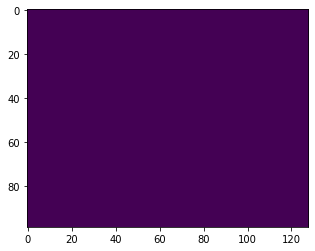

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


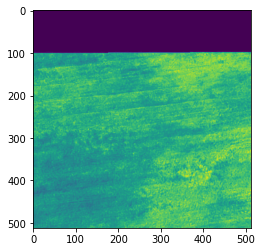

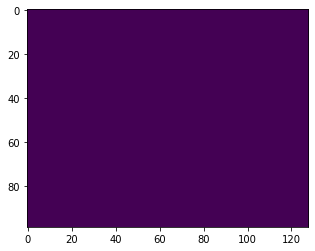

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


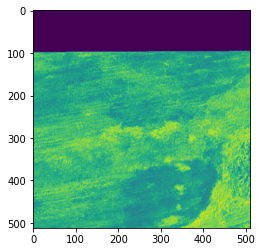

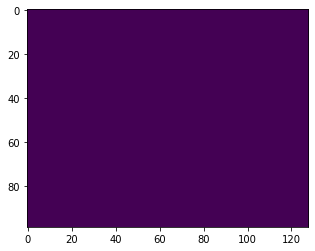

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


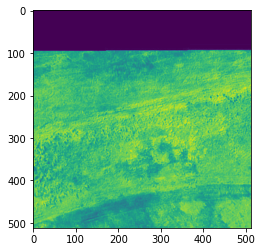

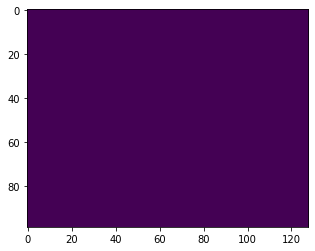

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


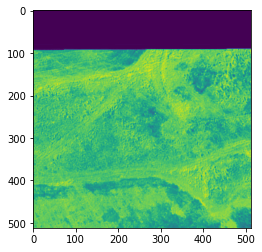

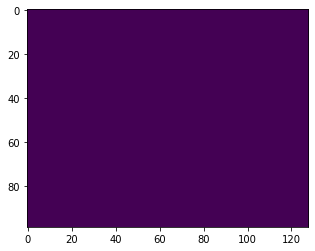

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


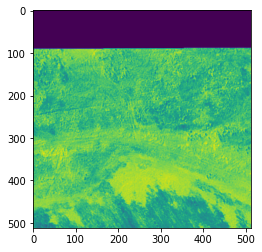

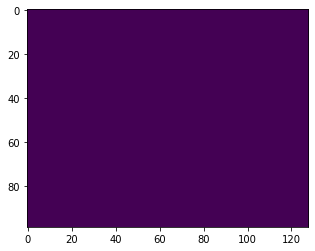

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


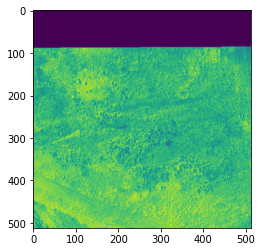

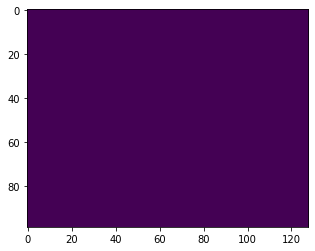

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


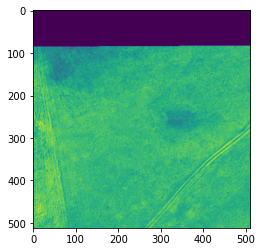

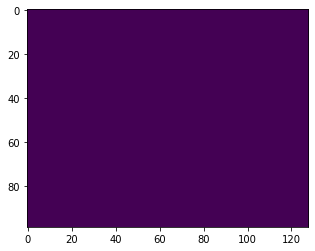

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


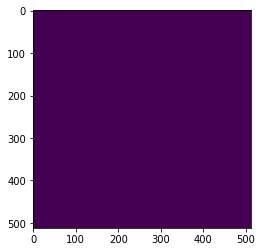

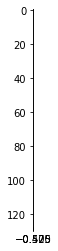

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


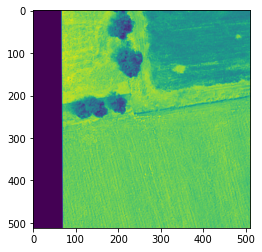

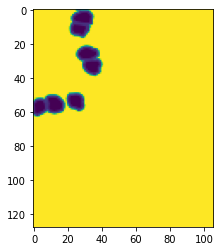

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


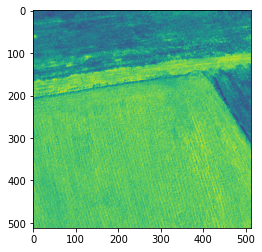

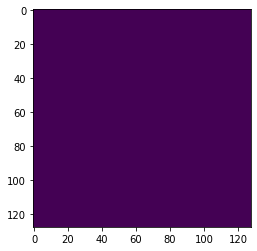

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


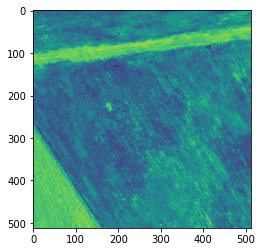

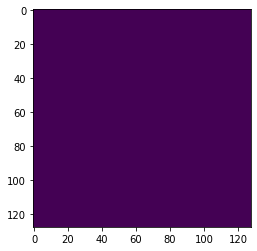

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


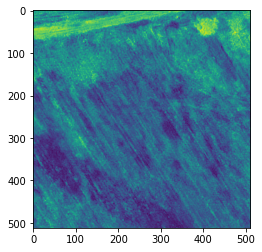

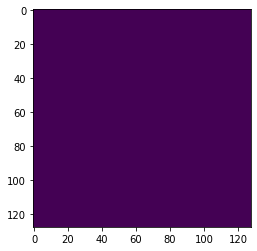

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


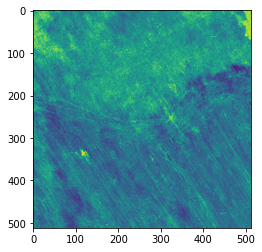

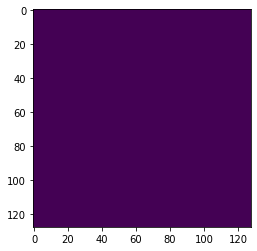

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


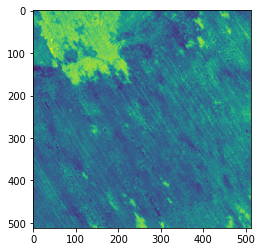

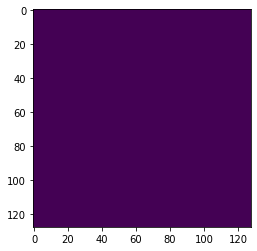

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


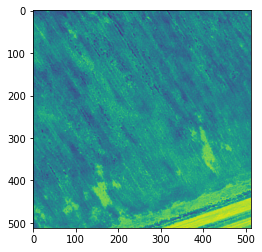

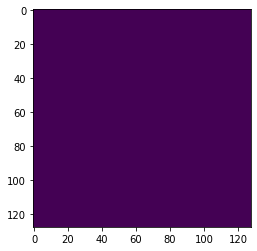

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


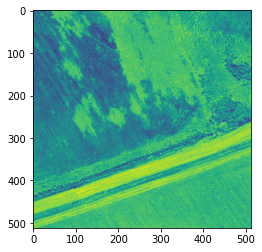

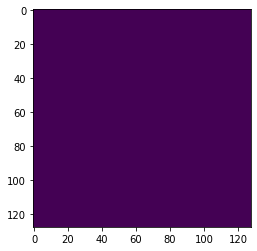

Size of cutout window in px: 511.99999999955287 x 511.9999999995484


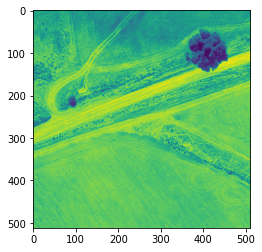

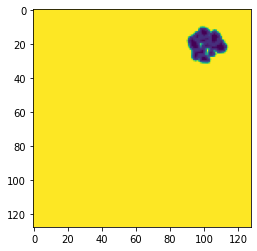

In [79]:
compare_satellite_label("2629BD_2018.tif", "merged_22_02_13_black-144dpi.tif")

In [66]:
inspect_tif_resolution(path_satellite + "2629BD_2018.tif")
inspect_tif_resolution(path_labels + "merged_22_02_13_black-144dpi.tif")

Resolution: 2.3728143101288307e-06 x 2.3728143101288515e-06
Resolution: 9.430457781766563e-06 x 9.430457781766563e-06


In [67]:
2.3728143101288307e-06 < 9.430457781766563e-06

True

In [40]:
preview_tif(path_labels + "merged_22_02_13_black-144dpi.tif") # do not try to display too large images

In [38]:
inspect_tif(gdal.Open(path_labels + "merged_22_02_13_black-144dpi.tif"))

Size is 26742 x 26684 x 4
Origin = (29.748224553, -26.24867817177567)
Pixel Size = (9.430457781766563e-06, -9.430457781766563e-06)
Min=0.000, Max=255.000
# Pixels in Image = (26742, 26684) with a Raster Count of 4
Size of one Pixel in cm = (0.9430457781766562, -0.9430457781766562)
Size Covered by Image / Image Size = (252.19m, 251.64m)


In [12]:
# compare_satellite_label("2629BD_2018.tif", "whole_image.tif")

## 2. Cleanup

In [13]:
def number_of_files_in_dir(dir: str = cutouts_path):
    number_of_files_in_dir.initial_count = 0
    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            number_of_files_in_dir.initial_count += 1
    return number_of_files_in_dir.initial_count

In [14]:
def remove_cutouts():
    if cutouts_path:
        number_of_files_in_dir()
        print("{} files are being deleted.".format(number_of_files_in_dir.initial_count))
        for f in os.listdir(cutouts_path):
            if f == ".ipynb_checkpoints": continue
            print(os.path.join(cutouts_path, f))
            os.remove(os.path.join(cutouts_path, f))
remove_cutouts()

# 3. Notes

## Data Preparation
- random sampling (!) for training
- Normalization → why so weird?
    - locally normalized the patches with a 40% probability (both the NDVI and panchromatic band) to zero mean and unit s.d. (=standard deviation)
    - other 60% normalized with mean and s.d. of the rectangle (of bigger area from which extracted patch)
    - “cope with varying atmospheric settings and reflectance in the satellite imagery and improved the model prediction in areas with cloud cover or burned surface.”
- Data Augmentation: cropping and zooming; piecewise affine, perspective transformation; and linear contrast enhancement

- disaggregation of clumped trees was achieved by giving the spaces between crowns a larger weight than other spaces during the learning process of the model

## Prediction
- 256 x 256 px with 12% overlap of patches (a technique sometimes referred to as test time augmentation)
- interim insights:
    - tree cover and density in later-dry season images (mainly March) are underestimated by up to one fourth
    - low sun azimuth angle and large off-nadir angle, tree cover tends to be underestimated

## Evaluation
- test dataset
    - randomly distributing 100 plots (a 256 × 256 pixels)
    - created independently  & not included in model development → avoiding the bias of adaptive data analysis (?)
    - manually labelled all tree crowns in the test plots
- confusion matrix
    - FN: 5% of the labelled trees were missed
    - true-positive rate (TPR=TP/TP+FN): 75% (25% of the area covered by labelled trees was missed in the predictions)
    - false-positive rate (FPR=FP/FP+TN): 2% (area labelled as background was classified as tree canopy)
    - 3.8% not predicted as individual trees but categorized as clumped canopies
- r^2 = 0.97 (slope = 1.00) for tree density, 0.95 (slope = 0.87) for canopy cover and 0.92 (slope = 0.77) for mean crown size
    - r^2 bzw. Determinationskoeffizient: wie dicht die Daten an der angepassten Regressionslinie liegen
        - slight underestimation of the canopy cover and mean crown size because of hyper-parameter selection and disaggregation of clumped canopies

## Result
- output:
    - spatial database includes each detected tree, its crown size in m2, and mean annual rainfall, land use and soil
        - Copernicus land-use data: ‘urban’ and ‘cropland’ classes
        - savannah classes were grassland, shrubland, open forest and bare areas
    - raster maps: 100 × 100-m (1-ha) grids with centroids of tree crowns ⇒ mean crown size, total canopy cover per hectare (in %), density of {crowns, shrubs, small trees, large trees, objects >200m2 (lvery large trees or unseparated clumped trees)} per hectare
- tree density and coverage develop along the rainfall gradient (Fig. 3)
    - very sparse in the hyper-arid Sahara Desert in the north (0.7 ± 2.6 (mean ± s.d.) trees per hectare, and 0.1 ± 4% canopy cover),
    - through scattered trees in arid (on average 9.9 ± 13.2 trees per hectare, and 1.6 ± 2.9% cover) and
    - semi-arid (on average 30.1 ± 29.0 trees per hectare, and 5.6 ± 5.9% cover) lands,
    - into denser patterns in the sub-humid south (on average 47 ± 30 trees per hectare, and 13.3 ± 9.4% cover)
- Tree Crown Size
    - Trees with a crown size of 3–15 m2 account for the majority of the density, but contribute only a little to the overall canopy cover
    - Small crowns dominate low-rainfall zones; beyond 150- and 300-mm-per-year rainfall, larger crown sizes appear and gradually increase in density to make up large parts of the coverage (Fig. 3a), while the smaller crown-size class (3–15 m2) decreases in density in the transition between the semi-arid and sub-humid zone.
    - contribution of very large trees: to the canopy cover is 6% (Fig. 3a) → accounting only for large patches of vegetation in canopy-cover assessments severely underestimates the total density and canopy cover 
    [da wenig ausmacht von canopy cover, aber bei bisheriger Recherche nur diese beachtet → erhebliche Unterschätzung von gesamter Baum-Dichte und Größe canopy cover]
    - estimate that 16–20% of the trees are in the 1–3-m2 crown-size rangen (By extrapolating the exponential model to crown size values of less than 3 m2 (which were not mapped in our study))
    - large crown sizes are located mainly in farmlandslarge crown sizes are located mainly in farmlands
- On average, canopy cover and tree density on sandy soils increase only weakly with rainfall, which suggests that the observed latitudinal increases (Fig. 1b) are closely related to the increasing dominance of non-sandy soils in the sub-humid zone (Fig. 3c, f, Extended Data Fig. 4b). The peak in both tree density and cover observed at around 400-mm-per-year rainfall reflects the man- aged agroforestry parklands in the semi-arid Sahel21.
- Studies often disagree on definitions for woody plants, crown cover and forests, which leads to misinterpretations and a con- tinuing uncertainty as to the number and size of trees in savannah regions (8,19,20)
- the results elucidate how widely used definitions of tree cover8,20 are miss- ing most of the trees and tree cover in these regions, because they are not designed to include isolated, non-forest trees